## 備註：目前沒有對XGBoost進行調參。

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier

import itertools
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

np.set_printoptions(suppress=True)

In [2]:
yelpZip_preprocessed = pd.read_pickle('data/processed/yelpZip_preprocessed.pkl')

yelpZip_data = yelpZip_preprocessed.copy()
yelpZip_data.head()

,userId,prodId,date,content,content_len,label,rating,average_review_similarity,max_review_similarity,review_count_today,...,neg,neu,pos,compound,cap_word_count,digit_word_count,absolute_compound,length_deviation,review_count,extreme_rating_ratio
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0,0.000000,0.0000,1,...,0.513,0.487,0.000,-0.9287,0,0,0.9287,0.527778,1,0.0
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0,0.000000,0.0000,1,...,0.195,0.584,0.221,0.6128,0,2,0.6128,0.508065,1,0.0
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0,0.162733,0.3298,1,...,0.000,0.610,0.390,0.9153,1,0,0.9153,0.520000,4,0.0
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0,0.000000,0.0000,1,...,0.016,0.614,0.370,0.9954,1,0,0.9954,0.446352,1,0.0
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0,0.000000,0.0000,1,...,0.000,0.518,0.482,0.9945,0,0,0.9945,0.480263,1,0.0


# Experiment 1  - without text features

## Prepare dataset to feed into model

In [3]:
yelpZip_data['label'].replace(1, True, inplace=True)
yelpZip_data['label'].replace(-1, False, inplace=True)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(yelpZip_data.drop('label',axis=1), yelpZip_data['label'], test_size=0.25, random_state=42)

In [5]:
features = ['average_review_similarity', 'max_review_similarity', 'review_count_today', 'rating_deviation', 'tokenize_content_len',
           'absolute_compound', 'cap_word_count', 'digit_word_count', 'length_deviation', 'review_count', 'extreme_rating_ratio']

x_train = x_train[features]
x_test = x_test[features]

## Train and Evaluate

### Experiment 1A. Without Oversampling

Training accuracy: 0.8706928280987101
Test accuracy: 0.8693986197831087

              precision    recall  f1-score   support

       False       0.59      0.04      0.08     20153
        True       0.87      1.00      0.93    131997

    accuracy                           0.87    152150
   macro avg       0.73      0.52      0.51    152150
weighted avg       0.84      0.87      0.82    152150



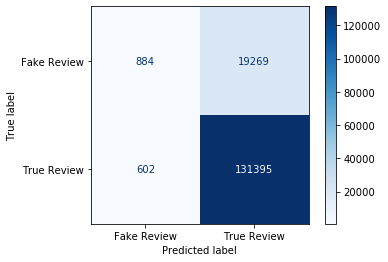

Complete in 1.0m 3.56196665763855s


In [6]:
# Boosting
since = time.time()

classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, max_features=0.5, random_state=42)
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)

print(f'Training accuracy: {classifier.score(x_train, y_train)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [7]:
print('feature importances:')
index = sorted(range(len(features)), key=lambda k: classifier.feature_importances_[k], reverse=True)
fi_sort = sorted(classifier.feature_importances_, reverse=True)
for i in range(len(features)):
    print(f'{fi_sort[i]:.7f} {features[index[i]]}')

feature importances:
0.2772629 average_review_similarity
0.2652798 max_review_similarity
0.1656700 review_count
0.1075021 rating_deviation
0.0597620 review_count_today
0.0505507 tokenize_content_len
0.0372743 extreme_rating_ratio
0.0197718 length_deviation
0.0104934 absolute_compound
0.0044261 cap_word_count
0.0020069 digit_word_count


### Experiment 1B. With Oversampling

In [8]:
since = time.time()

ros = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = ros.fit_resample(x_train, y_train)

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 2.171299695968628s


Training accuracy: 0.7956694056319185
Test accuracy: 0.7257246138678936

              precision    recall  f1-score   support

       False       0.29      0.76      0.42     20153
        True       0.95      0.72      0.82    131997

    accuracy                           0.73    152150
   macro avg       0.62      0.74      0.62    152150
weighted avg       0.86      0.73      0.77    152150



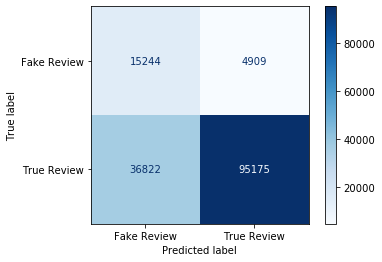

Complete in 2.0m 9.473586559295654s


In [9]:
# Boosting
since = time.time()

classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, max_features=0.5, random_state=42)
classifier.fit(x_train_oversampled, y_train_oversampled)
score = classifier.score(x_test, y_test)

print(f'Training accuracy: {classifier.score(x_train_oversampled, y_train_oversampled)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [10]:
print('feature importances:')
index = sorted(range(len(features)), key=lambda k: classifier.feature_importances_[k], reverse=True)
fi_sort = sorted(classifier.feature_importances_, reverse=True)
for i in range(len(features)):
    print(f'{fi_sort[i]:.7f} {features[index[i]]}')

feature importances:
0.3583736 review_count
0.2218131 average_review_similarity
0.1243447 extreme_rating_ratio
0.0837943 max_review_similarity
0.0464148 length_deviation
0.0415630 review_count_today
0.0407951 tokenize_content_len
0.0376391 rating_deviation
0.0213908 absolute_compound
0.0119747 cap_word_count
0.0118969 digit_word_count


# Experiment 2 - only text features

## Prepare dataset to feed into model

In [11]:
x_train, x_test, y_train, y_test = train_test_split(yelpZip_data.drop('label',axis=1), yelpZip_data['label'], test_size=0.25, random_state=42)

### 1. Transform corpus to vector

In [12]:
since = time.time()

vectorizer = CountVectorizer(max_features=15000)
vectorizer.fit(x_train['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 20.010318279266357s


In [13]:
since = time.time()

x_train = vectorizer.transform(x_train['corpus'])
x_test  = vectorizer.transform(x_test['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 26.395851135253906s


### 2. feature selection：chi-square

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pick_K = SelectKBest(chi2, k=150)
x_train_selected = pick_K.fit_transform(x_train, y_train)
print("x_train_selected shape:", x_train_selected.shape)

x_test_selected = pick_K.transform(x_test)  # transform不用Y，因為已經決定好要那些特徵了
print("x_test_selected shape:", x_test_selected.shape)

x_train_selected shape: (456448, 150)
x_test_selected shape: (152150, 150)


In [15]:
features_text = []
mask = pick_K.get_support()
for bool, feature in zip(mask, vectorizer.get_feature_names()):
    if bool:
        features_text.append(feature)

## Train and Evaluate

### Experiment 2A. Without Oversampling

Training accuracy: 0.8683201591418956
Test accuracy: 0.8676897798225436

              precision    recall  f1-score   support

       False       0.56      0.00      0.01     20153
        True       0.87      1.00      0.93    131997

    accuracy                           0.87    152150
   macro avg       0.71      0.50      0.47    152150
weighted avg       0.83      0.87      0.81    152150



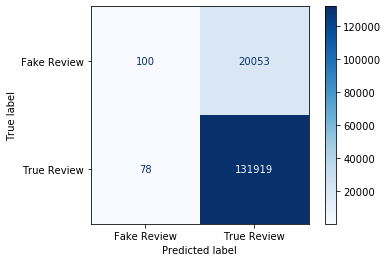

Complete in 1.0m 15.448861122131348s


In [16]:
# Boosting
since = time.time()

classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, max_features=0.5, random_state=42)
classifier.fit(x_train_selected, y_train)
score = classifier.score(x_test_selected, y_test)

print(f'Training accuracy: {classifier.score(x_train_selected, y_train)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test_selected)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test_selected, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [17]:
print('feature importances:')
index = sorted(range(len(classifier.feature_importances_)), key=lambda k: classifier.feature_importances_[k], reverse=True)
fi_sort = sorted(classifier.feature_importances_, reverse=True)
for i in range(len(features_text)):
    print(f'{fi_sort[i]:.7f} {features_text[index[i]]}')

feature importances:
0.0622744 pretty
0.0396148 owner
0.0368350 manager
0.0348879 sauce
0.0318742 good
0.0311791 pork
0.0299907 customer
0.0279285 rude
0.0270998 im
0.0237379 also
0.0229854 really
0.0209338 brunch
0.0203812 delicious
0.0203182 staff
0.0188843 little
0.0188798 bit
0.0186533 worst
0.0183038 got
0.0171260 came
0.0167588 ive
0.0162933 flavor
0.0151332 come
0.0148766 definitely
0.0146211 horrible
0.0130884 tasty
0.0127620 egg
0.0125481 id
0.0121420 cheese
0.0120782 side
0.0117620 youre
0.0114730 sweet
0.0112610 though
0.0110351 noodle
0.0109414 star
0.0109211 spot
0.0101552 small
0.0100021 fried
0.0090879 get
0.0085992 super
0.0074713 probably
0.0074239 cute
0.0070475 spicy
0.0070339 wasnt
0.0068461 solid
0.0068216 like
0.0062567 seating
0.0062410 ordered
0.0061171 fry
0.0058796 crispy
0.0057592 beer
0.0056792 there
0.0056108 didnt
0.0053149 sandwich
0.0051897 dumpling
0.0049382 decent
0.0044009 flavorful
0.0038808 space
0.0037418 option
0.0036376 ill
0.0035418 line
0.00352

### Experiment 2B. With Oversampling

In [18]:
since = time.time()

ros = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = ros.fit_resample(x_train_selected, y_train)

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 1.0m 52.53362226486206s


Training accuracy: 0.7954687164729196
Test accuracy: 0.6858429181728557

              precision    recall  f1-score   support

       False       0.22      0.54      0.31     20153
        True       0.91      0.71      0.80    131997

    accuracy                           0.69    152150
   macro avg       0.56      0.62      0.55    152150
weighted avg       0.82      0.69      0.73    152150



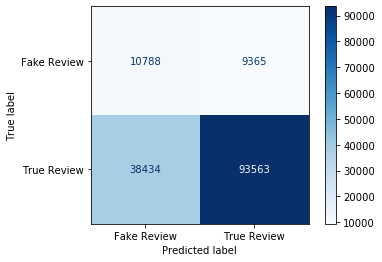

Complete in 2.0m 16.77055048942566s


In [19]:
# Boosting
since = time.time()

classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, max_features=0.5, random_state=42)
classifier.fit(x_train_oversampled, y_train_oversampled)
score = classifier.score(x_test_selected, y_test)

print(f'Training accuracy: {classifier.score(x_train_oversampled, y_train_oversampled)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test_selected)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test_selected, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [20]:
print('feature importances:')
index = sorted(range(len(classifier.feature_importances_)), key=lambda k: classifier.feature_importances_[k], reverse=True)
fi_sort = sorted(classifier.feature_importances_, reverse=True)
for i in range(len(features_text)):
    print(f'{fi_sort[i]:.7f} {features_text[index[i]]}')

feature importances:
0.0566118 also
0.0510919 pretty
0.0347371 im
0.0285079 little
0.0274190 sauce
0.0238621 come
0.0233938 bit
0.0230165 got
0.0222798 ive
0.0221522 ordered
0.0219769 really
0.0219443 definitely
0.0212141 tasty
0.0210952 pork
0.0186228 delicious
0.0184713 though
0.0175567 small
0.0169717 spot
0.0160553 came
0.0160399 flavor
0.0150257 like
0.0143948 side
0.0139180 cheese
0.0136360 youre
0.0133310 star
0.0133190 brunch
0.0126416 well
0.0118864 super
0.0116286 think
0.0105441 try
0.0102483 perfect
0.0093827 get
0.0091952 fried
0.0089521 menu
0.0088337 still
0.0086385 sweet
0.0084272 probably
0.0075720 right
0.0073832 decent
0.0073578 happy
0.0072936 thing
0.0072451 id
0.0071298 much
0.0071211 special
0.0068771 next
0.0068460 beer
0.0067287 huge
0.0067273 lot
0.0066561 dont
0.0065494 wasnt
0.0065049 seating
0.0062743 option
0.0057868 dish
0.0057640 egg
0.0056835 wait
0.0056470 good
0.0056345 enough
0.0051245 didnt
0.0051238 sandwich
0.0049145 sure
0.0048941 nice
0.0048795 

# Experiment 3 - both text features & behavior features

## Prepare dataset to feed into model

In [21]:
x_train, x_test, y_train, y_test = train_test_split(yelpZip_data.drop('label',axis=1), yelpZip_data['label'], test_size=0.25, random_state=42)

### 1. Transform corpus to vector

In [22]:
since = time.time()

vectorizer = CountVectorizer(max_features=15000)
vectorizer.fit(x_train['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 19.46735119819641s


In [23]:
since = time.time()

x_train_text = vectorizer.transform(x_train['corpus'])
x_test_text  = vectorizer.transform(x_test['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 25.2117600440979s


### 2. feature selection：chi-square

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pick_K = SelectKBest(chi2, k=150)
x_train_selected = pick_K.fit_transform(x_train_text, y_train)
print("x_train_selected shape:", x_train_selected.shape)

x_test_selected = pick_K.transform(x_test_text)  # transform不用Y，因為已經決定好要那些特徵了
print("x_test_selected shape:", x_test_selected.shape)

x_train_selected shape: (456448, 150)
x_test_selected shape: (152150, 150)


In [25]:
features_text = []
mask = pick_K.get_support()
for bool, feature in zip(mask, vectorizer.get_feature_names()):
    if bool:
        features_text.append(feature)

### 3. Concat selected text features with other behavior features

In [26]:
features = ['average_review_similarity', 'max_review_similarity', 'review_count_today', 'rating_deviation', 'tokenize_content_len',
           'absolute_compound', 'cap_word_count', 'digit_word_count', 'length_deviation', 'review_count', 'extreme_rating_ratio']

x_train = sp.sparse.hstack((x_train_selected, x_train[features].values))
x_test = sp.sparse.hstack((x_test_selected, x_test[features].values))

In [27]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (456448, 161)
x_test shape: (152150, 161)


In [28]:
features_all = features_text + features
print(len(features_all))
print(features_all[:5])

161
['also', 'around', 'back', 'bacon', 'bar']


## Train and Evaluate

### Experiment 3A. Without Oversampling

Training accuracy: 0.8711419482613573
Test accuracy: 0.8696023660860992

              precision    recall  f1-score   support

       False       0.58      0.05      0.10     20153
        True       0.87      0.99      0.93    131997

    accuracy                           0.87    152150
   macro avg       0.73      0.52      0.51    152150
weighted avg       0.83      0.87      0.82    152150



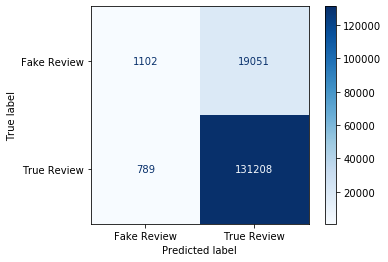

Complete in 2.0m 34.25945830345154s


In [29]:
# Boosting
since = time.time()

classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, max_features=0.5, random_state=42)
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)

print(f'Training accuracy: {classifier.score(x_train, y_train)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [30]:
print('feature importances:')
index = sorted(range(len(classifier.feature_importances_)), key=lambda k: classifier.feature_importances_[k], reverse=True)
fi_sort = sorted(classifier.feature_importances_, reverse=True)
for i in range(len(features_all)):
    print(f'{fi_sort[i]:.7f} {features_all[index[i]]}')

feature importances:
0.2538155 review_count
0.2406021 max_review_similarity
0.1706555 average_review_similarity
0.0898304 rating_deviation
0.0530338 review_count_today
0.0475260 extreme_rating_ratio
0.0395705 tokenize_content_len
0.0140287 length_deviation
0.0088929 owner
0.0057128 absolute_compound
0.0041097 customer
0.0035663 got
0.0035185 ordered
0.0032399 pork
0.0031913 staff
0.0027642 pretty
0.0027468 ramen
0.0027075 manager
0.0026164 came
0.0021957 flavor
0.0020431 sauce
0.0019879 im
0.0019653 brunch
0.0016712 didnt
0.0016602 cap_word_count
0.0015318 wasnt
0.0014638 egg
0.0013116 super
0.0012018 star
0.0011003 delicious
0.0010845 dumpling
0.0009915 place
0.0009400 id
0.0009092 noodle
0.0009092 small
0.0007962 ive
0.0007866 definitely
0.0007690 worst
0.0006891 cheese
0.0006532 line
0.0005951 rude
0.0005738 horrible
0.0005658 cute
0.0005629 waffle
0.0005507 digit_word_count
0.0005443 side
0.0005188 fried
0.0005124 youre
0.0004987 table
0.0004972 good
0.0004461 little
0.0004103 fry


### Experiment 3B. With Oversampling

In [31]:
since = time.time()

ros = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = ros.fit_resample(x_train, y_train)

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 2.0m 59.66137886047363s


Training accuracy: 0.8969000467012508
Test accuracy: 0.8272954321393362

              precision    recall  f1-score   support

       False       0.36      0.41      0.39     20153
        True       0.91      0.89      0.90    131997

    accuracy                           0.83    152150
   macro avg       0.64      0.65      0.64    152150
weighted avg       0.84      0.83      0.83    152150



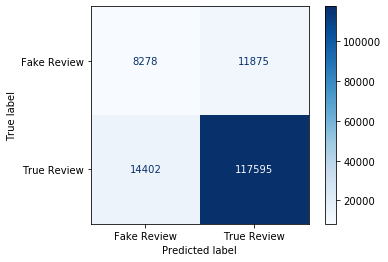

Complete in 6.0m 50.455527544021606s


In [32]:
# Boosting
since = time.time()

classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, max_features=0.5, random_state=42)
classifier.fit(x_train_oversampled, y_train_oversampled)
score = classifier.score(x_test, y_test)

print(f'Training accuracy: {classifier.score(x_train_oversampled, y_train_oversampled)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [33]:
print('feature importances:')
index = sorted(range(len(classifier.feature_importances_)), key=lambda k: classifier.feature_importances_[k], reverse=True)
fi_sort = sorted(classifier.feature_importances_, reverse=True)
for i in range(len(features_all)):
    print(f'{fi_sort[i]:.7f} {features_all[index[i]]}')

feature importances:
0.3447670 review_count
0.0885605 max_review_similarity
0.0831977 review_count_today
0.0356592 tokenize_content_len
0.0288640 good
0.0222273 extreme_rating_ratio
0.0211460 average_review_similarity
0.0197692 get
0.0181267 cap_word_count
0.0174645 really
0.0173002 also
0.0170975 delicious
0.0132159 definitely
0.0129026 ive
0.0126892 rating_deviation
0.0125795 little
0.0109412 back
0.0106095 got
0.0105143 im
0.0100636 dont
0.0097990 wait
0.0087650 come
0.0081810 chicken
0.0081102 ordered
0.0080738 place
0.0079834 like
0.0077668 nice
0.0073651 staff
0.0068237 small
0.0065539 sauce
0.0061720 pretty
0.0061030 try
0.0055199 cheese
0.0052223 one
0.0043326 tasty
0.0042616 digit_word_count
0.0040918 spot
0.0038364 came
0.0037345 star
0.0035771 well
0.0034319 menu
0.0033473 absolute_compound
0.0033457 pork
0.0031801 owner
0.0030270 brunch
0.0028951 perfect
0.0026376 bit
0.0026054 beer
0.0022981 though
0.0021584 dish
0.0021478 would
0.0020925 meal
0.0019077 flavor
0.0018699 su